# Diffusion Equation Solver

In this notebook, we attempt to program a high-accuracy numerical solver for the 1D diffusion equation with a Gaussian initial condition.

Libraries and plotting preferences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = [8, 6]

## Simulation Set-Up

Define grid in position and momentum$\leftrightarrow$wave vector.

In [2]:
L = 10
xmin, xmax = -L/2, L/2
res = 1000
x_arr = np.linspace(xmin, xmax, res)
dx = (x_arr[1]-x_arr[0])

kmax = np.pi/dx
kmin = 2*np.pi/L
k_pos = np.arange(0, kmax, kmin)
k_neg = np.arange(-kmax, 0, kmin)
k_arr = np.concatenate([k_pos, k_neg])

Define mass distribution. (Make it artificially periodic for better FFT performance.)

In [3]:
sig = L/40
f_arr = (2*np.pi*sig**2)**(-0.5)*np.exp(-(x_arr**2.0)/(2*sig**2))
f_arr += (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-L)**2.0)/(2*sig**2))
f_arr += (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr+L)**2.0)/(2*sig**2))
f_arr += (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-2*L)**2.0)/(2*sig**2))
f_arr += (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr+2*L)**2.0)/(2*sig**2))

Check normalization of mass distribution.

In [4]:
(f_arr*dx).sum()

1.0000000000000002

Plot mass distribution.

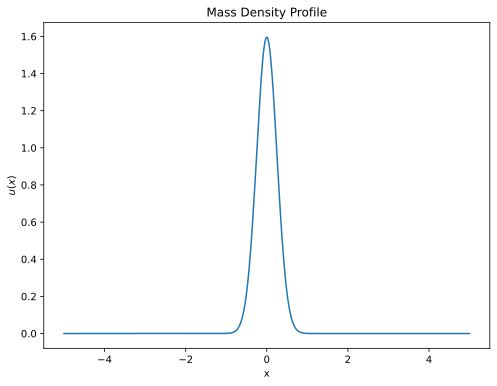

In [5]:
plt.plot(x_arr, f_arr)
plt.xlabel("x")
plt.ylabel("$u(x)$")
plt.title("Mass Density Profile")
plt.show()

Perform spatial derivatives of mass distribution using FFT.

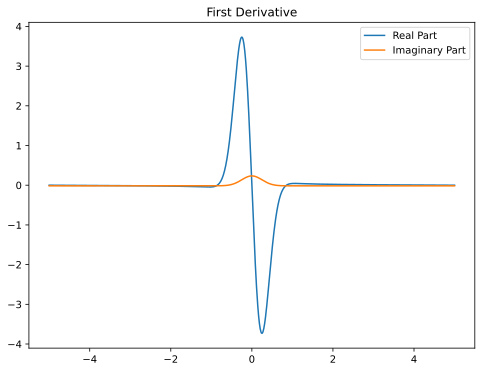

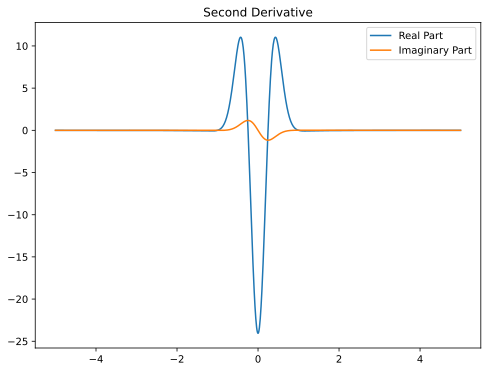

In [6]:
f_arr_fft = np.fft.fft(f_arr) 
deriv_f_arr = np.fft.ifft(1j*k_arr*f_arr_fft)

plt.plot(x_arr, np.real(deriv_f_arr),label="Real Part")
plt.plot(x_arr, np.imag(deriv_f_arr),label="Imaginary Part")
plt.title("First Derivative")
plt.legend()
plt.show()

deriv_f_arr_2 = np.fft.ifft(-(k_arr**2)*f_arr_fft)
plt.plot(x_arr, np.real(deriv_f_arr_2),label="Real Part")
plt.plot(x_arr, np.imag(deriv_f_arr_2),label="Imaginary Part")
plt.title("Second Derivative")
plt.legend()
plt.show()

## Time-Stepping

We wish to solve the diffusion equation, $u_t=D u_{xx}$ in our simulation box for some interval of time.

Function to evaluate RHS.

In [7]:
def deriv(u,D):
    return D*np.fft.ifft(-(k_arr**2)*np.fft.fft(u))

### Attempt 1: Forward Euler Technique

The Forward Euler technique implements the time-stepping scheme $$u(x,t+dt) = u(x,t) + D u_{xx}(x,t)dt$$

Time-stepper parameters and initial conditions:

In [9]:
dt_FE = 0.001
T_FE = 100
s_FE = int(np.ceil(T_FE/dt_FE))
u_FE = np.zeros([s_FE,len(x_arr)],dtype = 'complex_') # Fixes "ComplexWarning: Casting complex values to real discards the imaginary part"
u_FE[0] = f_arr+0.0*1j*f_arr
D_FE = 0.01

Perform numerical integration

In [10]:
for t in range(0,s_FE-1):
    u_FE[t+1] = u_FE[t]+dt_FE*deriv(u_FE[t],D_FE)
    
# NOTE: somewhere we appear to be throwing out complex part. Shouldn't do that!

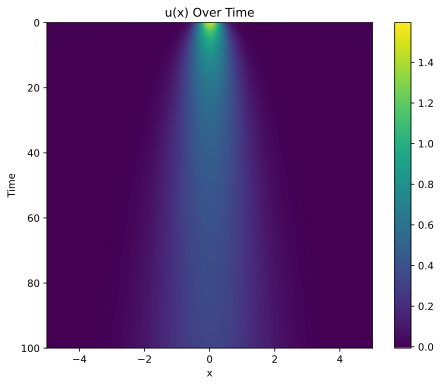

In [11]:
plt.imshow(np.real(u_FE),aspect="0.1",extent=[-L/2,L/2,T_FE,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

Test mass conservation

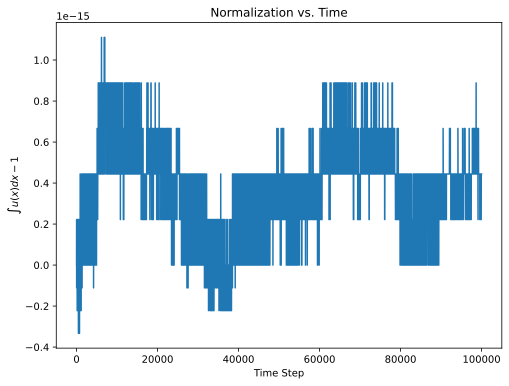

In [12]:
norm = np.array([(u_FE[t]*dx).sum() for t in range(s_FE)], dtype="complex_")
plt.plot(np.real(norm) - 1)
plt.xlabel("Time Step")
plt.ylabel("$\int u(x)dx -1$")
plt.title("Normalization vs. Time")
plt.show()

In [14]:
np.max(np.imag(norm))

4.163336342344337e-17

### Analysis

This thing appears to be diffusing! This is great. However, it requires a very small step size, otherwise it breaks.

Failure mode:

/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


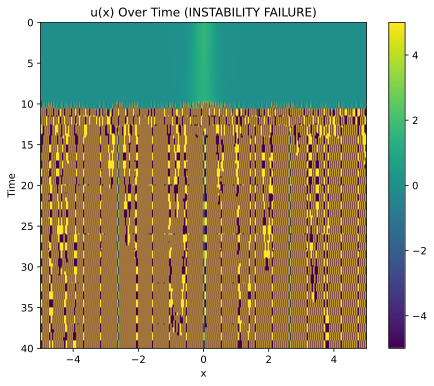

In [15]:
dt_FE_fail = 0.01
T_FE_fail = 100
s_FE_fail = int(np.ceil(T_FE_fail/dt_FE_fail))
u_FE_fail = np.zeros([s_FE_fail,len(x_arr)])
u_FE_fail[0] = f_arr
D_FE_fail = 0.1

for t in range(0,s_FE_fail-1):
    u_FE_fail[t+1] = u_FE_fail[t]+dt_FE_fail*deriv(u_FE_fail[t],D_FE_fail)
    
plt.imshow(np.real(u_FE_fail[0:40]),aspect="0.25",extent=[-L/2,L/2,40,0],vmin=-5,vmax=5)
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time (INSTABILITY FAILURE)")
plt.colorbar()
plt.show()

Furthermore, the small step size leads to slow simulations and very large data sets.

Number of bytes:

In [16]:
u_FE.size*8

800000000

(In case you don't believe me, run this and check file size.)

In [32]:
#np.save("test.npy",u_FE)

$\textbf{TO DO: Compare pointwise with analytical solution.}$

$$\frac{\text{max}_{x,t}|u_{\text{analytical}}(x,t)-u_{\text{num}}(x,t)|}{\text{max}_{x,t}|u_{\text{analytical}}(x,t)|}$$

### Attempt 2: Adams-Bashforth-Milne (ABM)

The ABM technique implements the time-stepping scheme 

Predictor:
$$p(x,t+dt) = \frac{u(x,t)+u(x,t-dt)}{2}+\frac{dt}{48}\Bigl(119 u_t(x,t) - 99 u_t(x,t-dt)+69 u_t(x,t-2 dt)-17 u_t(x,t-3 dt)\Bigr)$$

Modifier:
$$m(x,t+dt) = p(x,t+dt)-\frac{161}{170}\Bigl(p(x,t)-c(x,t)\Bigr)$$

Corrector:
$$c(x,t+dt) = \frac{u(x,t)+u(x,t-dt)}{2}++\frac{dt}{48}\Bigl(17 m_t(x,t+dt) + 51 u_t(x,t)+ 3 u_t(x,t-dt) + u_t(x,t-2 dt) \Bigr)$$

Stepper:
$$u(x,t+dt) = c(x,t+dt) + \frac{9}{170}\Bigl(p(x,t+dt)-c(x,t+dt)\Bigr)$$

(Source: https://arxiv.org/abs/2009.00745)

Time-stepper parameters and initial conditions:

In [18]:
dt_ABM = 0.001
T_ABM = 10
s_ABM = int(np.ceil(T_ABM/dt_ABM))
u_ABM = np.zeros([s_ABM,len(x_arr)],dtype="complex_")
D_ABM = 0.1
# Need 4 initial values now
u_ABM[0]=f_arr
for t in range(0,3):
    u_ABM[t+1] = u_ABM[t]+dt_ABM*deriv(u_ABM[t],D_ABM)

Perform numerical integration.

$\textbf{This doesn't work yet. I think the derivative starts to grow unbounded.}$

In [19]:
ps = np.zeros([s_ABM,len(x_arr)]) #WARNING: these start at 0. Arguably they should be initialized in some other way?
ms = np.zeros([s_ABM,len(x_arr)])
cs = np.zeros([s_ABM,len(x_arr)])
for t in range(2,s_ABM-1):
    
#    print(f"t = {t}, max(u) = {np.max(u_ABM[t])}, max(u_t) = {np.max(deriv(u_ABM[t],D_ABM))}")
    
    # Predictor
    ps[t+1] = (u_ABM[t] + u_ABM[t-1])/2 + (dt_ABM/48)*(119*deriv(u_ABM[t],D_ABM) - \
                     99*deriv(u_ABM[t-1],D_ABM) + \
                        69*deriv(u_ABM[t-2],D_ABM) - \
                        17*deriv(u_ABM[t-3],D_ABM) );
        
    # Modifier 
    ms[t+1] = ps[t+1]-(161/170)*(ps[t]-cs[t]);
    
    # Corrector
    cs[t+1] = (u_ABM[t] + u_ABM[t-1])/2 + (dt_ABM/48)*(17*deriv(ms[t+1],D_ABM) + \
        51*deriv(u_ABM[t],D_ABM) + 3*deriv(u_ABM[t-1],D_ABM) + deriv(u_ABM[t-2],D_ABM) );

    u_ABM[t+1] = cs[t+1]+(9/170)*(ps[t+1]-cs[t+1]);


/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/mattkafker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/mattkafker/opt/anaconda3/lib/p

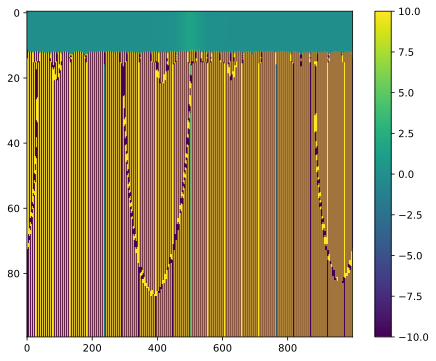

In [20]:
plt.imshow(np.real(u_ABM[0:100]),vmin=-10,vmax=10,aspect="10")
plt.colorbar()
plt.show()

### Attempt 3: 2nd Order Runge-Kutta

In [1]:
dt_RK = 0.001
T_RK = 10
s_RK = int(np.ceil(T_RK/dt_RK))
u_RK = np.zeros([s_RK,len(x_arr)],dtype="complex_")
D_RK = 0.1
# Need 4 initial values now
u_RK[0]=f_arr
for t in range(0,3):
    u_ABM[t+1] = u_ABM[t]+dt_ABM*deriv(u_ABM[t],D_ABM)

NameError: name 'np' is not defined